In [1]:
import numpy as np
import scipy.misc

from skimage import color, io
import time

ab_to_dist = {}
ab_to_closest_bucket = {}
reweighting_vector = np.load('../preprocessing/reweighting_vector.npy')

def image_path_to_image_and_distribution_tensor(path):
    '''Converts an image path to a LAB image and a [64, 64, 313] tensor of color distribution values.'''
    raw_img = io.imread(path)
    lab_img = color.rgb2lab(raw_img)

    img = lab_img[:, :, 1:3]
    dist = np.zeros([64, 64, 313])
    weights = np.zeros([64, 64])

    h, w, _ = dist.shape
    for x in xrange(w):
        for y in xrange(h):
            ab = tuple(np.floor(img[4 * x][4 * y]))
            dist[x][y] = _map_ab_to_distribution(ab)
            weights[x][y] = reweighting_vector[ab_to_closest_bucket[ab]]

    return lab_img[:, :, 0], dist, weights


def _gaussian(x, var):
    '''Gaussian on np array'''
    return np.exp(-(x**2) / (2 * var**2))


def _precompute_distributions():
    '''Precomputes the distribution we want for each integer a,b value.'''
    global ab_to_dist
    print "Precomputing distributions... will take a second"

    quantized_array = np.load('pts_in_hull.npy')

    for a in xrange(-130, 130):
        for b in xrange(-130, 130):
            tiled_ab = np.tile([a, b], (313, 1))

            distances = np.linalg.norm(quantized_array - tiled_ab, axis=1)
            d = distances.copy()
            d.sort()

            low_values = (distances > np.tile(d[4], (313)))
            gaussian_distances = _gaussian(distances, 5)
            gaussian_distances[low_values] = 0

            dist = gaussian_distances / np.sum(gaussian_distances)

            ab_to_dist[(a, b)] = dist
            ab_to_closest_bucket[(a, b)] = np.argmin(distances)
    print "Done"


def _map_ab_to_distribution(ab):
    '''Map an integer (a,b) tuple to a 313 deep distribution.'''
    if len(ab_to_dist) == 0:
        _precompute_distributions()

    return ab_to_dist[ab]

_precompute_distributions()


Precomputing distributions... will take a second
Done


0.000546023121843
0.00482380452947


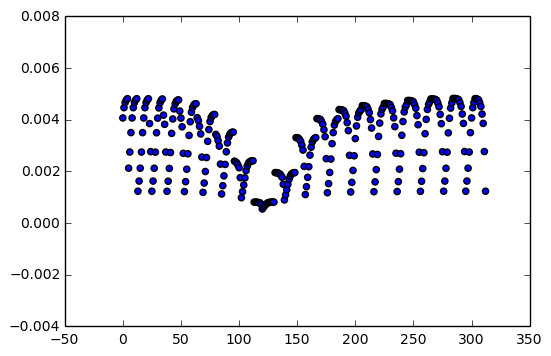

In [18]:
plt.scatter(range(313), reweighting_vector)
print min(reweighting_vector)
print max(reweighting_vector)


In [2]:
%matplotlib inline

import ujson, gzip

source = 'imagenet_train_256_saturation_values.json.gz'
f = ujson.load(gzip.open('../dataset_indexes/' + source, 'rt'))
all_paths = [path for path in f.keys() if f[path] > .1]


from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

path = '/root/persistant_data/datasets/imagenet/train256/' + all_paths[25]

img, dist, weights = image_path_to_image_and_distribution_tensor(path)
plt.imshow(img, cmap='gray')



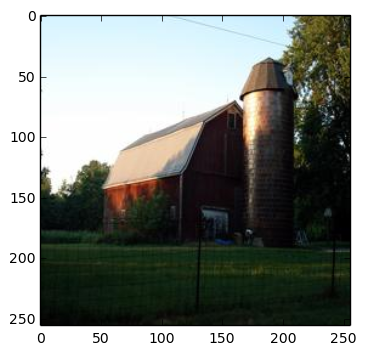

In [49]:
cshow = Image.open(path)
plt.imshow(cshow)

<matplotlib.colorbar.Colorbar instance at 0x7f7c0b018ea8>

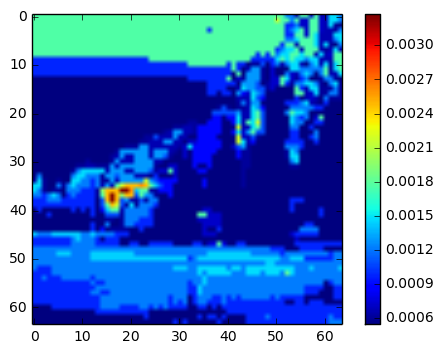

In [50]:
plt.imshow(weights)#, cmap='hot')
plt.colorbar()
